In [2]:
import torch
import torchvision
from torch import nn, Tensor
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets.vision import VisionDataset
from torchvision import transforms, utils
import numpy as np
from numpy import ndarray
from PIL import Image
import os
import matplotlib.pyplot as plt
from time import time
from skimage import io
from typing import List, Tuple, Dict
from glob import glob
import matplotlib.animation as animation
from IPython.display import HTML
import random

%matplotlib inline

Determine if we have a HDD or SSD.
If we have a HDD, then the CatsVsDogsDataset should be used for better performance as it loads whole dataset in memory. It may be counter intuitive, but using ImageFolder dataset performance problems arise as the time for multiple file openings cost a lot.

In [3]:
!cat /sys/block/sda/queue/rotational

1


## Helper functions

In [4]:
def get_sample_image(G, n_noise=100, im_size=64, num_classes=2, num_samples=64):
    # Generate random noise and labels (optional)
    Z = torch.randn(num_samples, n_noise).to(device)
    y = F.one_hot(torch.randint(0, num_classes, (num_samples,), dtype=torch.int64), num_classes).to(device)
    # Inference: G should be able to not use y if it is not meant to
    result = G(Z, y).cpu() 
    # Make a grid over this batch and transpose for numpy style: (H, W, V)
    img = torchvision.utils.make_grid(result, normalize=True).cpu()
    img = np.transpose(img.detach(), (1, 2, 0))
    return img

In [17]:
def visualize_loss(losses : Dict[str, List], N=100):
    """
    Only two keys: 'generator' and 'discriminator'.
    N is the number of example we use to compute the running mean.
    """

    fig = plt.figure(figsize=(8,8))
    axes = fig.gca()
    x = np.arange(len(tuple(losses.values())[0]))
    
    # Compute running mean
    loss_g = np.array(losses["generator"])
    loss_g_mean = np.zeros_like(loss_g)
    loss_g_mean[:N] = loss_g[:N]
    loss_g_mean[N-1:] = np.convolve(loss_g, np.ones((N,))/N, mode='valid')
    
    loss_d = np.array(losses["discriminator"])
    loss_d_mean = np.zeros_like(loss_d)
    loss_d_mean[:N] = loss_d[:N]
    loss_d_mean[N-1:] = np.convolve(loss_d, np.ones((N,))/N, mode='valid')
    
    l_g, = axes.plot(x, loss_g, linewidth=1, color="#9db9ed") # unpack!
    l_g_mean, = axes.plot(x, loss_g_mean, color="#3d6bbf")
    l_d, = axes.plot(x, loss_d, linewidth=1, color="#ebb573")
    l_d_mean, = axes.plot(x, loss_d_mean, color="#e3820b")
    
    lines = (l_g, l_g_mean, l_d, l_d_mean)
    
    axes.legend(lines, ("generator", f"generator running mean (N={N})", "discriminator", f"discriminator running mean (N={N})"), loc="upper right", shadow=True)
    axes.set_xlabel("Iteration")
    axes.set_ylabel("Value")
    axes.set_title("Losses")

In [5]:
def animate_image_list(im_list : List[ndarray], im_size=64):
    fig = plt.figure(figsize=(8,8))
    plt.axis("off")
    ims = [[plt.imshow(i, animated=True)] for i in im_list]
    ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)
    return ani.to_jshtml()

In [6]:
def train(generator : nn.Module, 
          discriminator : nn.Module, 
          criterion : nn.Module, 
          dataloader : torch.utils.data.DataLoader, 
          optims : dict, 
          device : torch.device, 
          n_noise=100,
          image_size=64,
          num_classes=2,
          epochs=1, 
          discriminator_steps=1, 
          batch_size=1):
    """
    Simultaneous training of generator and discriminator for multiple epochs.
    """
    
    losses = {"discriminator" : [], "generator" : []}
    
    images_list = []
    
    labels_ones = torch.ones((batch_size, 1)).to(device)
    labels_zeros = torch.zeros((batch_size, 1)).to(device)
    
    print("Start training...")
    print(f"Batch size: {batch_size}")
    
    step = 0
    since = time()
    for e in range(epochs):
        epoch_time = time()
        for i, (X, y) in enumerate(dataloader):
            ##########################################################
            ################## Train Discriminator ###################
            ##########################################################
            
            # p_data
            X, y = X.to(device), F.one_hot(y.long(), num_classes=num_classes).to(device)
            data_preds = discriminator(X, y)
            loss_data_discriminator = criterion(data_preds, labels_ones)
            
            # p_z
            Z = torch.randn(batch_size, n_noise).to(device)
            fake_preds = discriminator(generator(Z, y), y)
            loss_fake_discriminator = criterion(fake_preds, labels_zeros)
                        
            # Global discriminator loss : (Ex~p_data[log(D(x))] + Ez~p_z[1-log(D(G(z)))])
            loss_discriminator = loss_data_discriminator + loss_fake_discriminator
            discriminator.zero_grad()
            loss_discriminator.backward()

            losses["discriminator"].append(loss_discriminator.item())
            optims["discriminator"].step()

            ##########################################################
            #################### Train Generator #####################
            ##########################################################
            if i % discriminator_steps == 0:
                Z = torch.randn(batch_size, n_noise).to(device)
                fake_preds = discriminator(generator(Z, y), y)
                
                loss_generator = criterion(fake_preds, labels_ones)
                generator.zero_grad()
                loss_generator.backward()
                
                losses["generator"].append(loss_generator.item())
                optims["generator"].step()
            
            ##########################################################
            ################## Record performances ###################
            ##########################################################
            if step % 500 == 0 or (e == epochs-1 and (i == len(dataloader)-1)):
                print(f"Epoch {e} | Training step: {step}")
                print("Discriminator Loss: {}".format(losses['discriminator'][-1]))
                print("Generator Loss: {}".format(losses['generator'][-1]))
            
            if step % 1000 == 0:
                with torch.no_grad():
                    image = get_sample_image(generator, n_noise=n_noise, im_size=image_size)
                    images_list.append(image)
            
            step += 1
        print(f"Epoch time: {time() - epoch_time}")
    print(f"Total training time: {time() - since}")
                
    return losses, images_list

In [7]:
class CatsVsDogsDataset(VisionDataset):
    
    training_file = "data.pt"
    # There is no predefined train/val/test split for this dataset.
    classes = ["0 - Cat", "1 - Dog"]
    url = "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip"
    
    # Url picked at https://github.com/tensorflow/datasets/blob/v3.1.0/tensorflow_datasets/image_classification/cats_vs_dogs.py#L43
    
    def __init__(self, root, transform=None, target_transform=None, download=False):
        super(CatsVsDogsDataset, self).__init__(root, transform=transform, target_transform=target_transform)
        
        if download:
            self.download()
        
        if not self._check_exists():
            raise RuntimeError('Dataset not found.' +
                               ' You can use download=True to download it')
        
        data_file = self.training_file
        self.data, self.targets = torch.load(os.path.join(self.processed_folder, data_file))
           
            
    @property
    def raw_folder(self):
        return os.path.join(self.root, self.__class__.__name__, "raw")
    
    @property
    def processed_folder(self):
        return os.path.join(self.root, self.__class__.__name__, "processed")
    
    def _check_exists(self):
        return os.path.exists(os.path.join(self.processed_folder,self.training_file))
            
    def download_and_extract(self):
        """
        Download file at self.url to the folder self.raw_folder, then unzip it in the same folder
        """
        import wget
        import zipfile
        
        if not os.path.exists(self.raw_folder):
            print(f"Make dir '{self.raw_folder}'...")
            os.makedirs(self.raw_folder, exist_ok=True)
            
        # Download the dataset file at the right url
        path = os.path.join(self.raw_folder, self.url.split(os.sep)[-1])
        if not os.path.exists(path):
            print(f"Download {self.url} in {path}...")
            wget.download(self.url, path)
            # Unzip it in root
            print(f"Extract {path} in {self.raw_folder}")
            with zipfile.ZipFile(path) as f:
                f.extractall(path=self.raw_folder)
            print("Extraction successful")
        else:
            print("The dataset files have already been downloaded and extracted")
            

    def process_images(self) -> Tuple[List[Tensor], Tensor]:
        """
        Build tensors of images and labels for the dataset.
        """
        ########## Intermediate function ########
        def imread_list(pattern) -> List[Tensor]:
            import piexif
            problem_count = 0
            # Filter function
            def filter_image(path) -> bool:
                nonlocal problem_count
                try:
                    im = Image.open(path)
                    im.seek(0)
                    return True
                except:
                    problem_count += 1
                    print(f"Problem on image at '{path}'")
                    try: 
                        piexif.remove(path)
                    except:
                        print("Cannot remove the image using piexif")
                    return False
            
            filenames = glob(pattern)
            assert len(filenames) > 0
            
            filtered_files = filter(filter_image, filenames)
            print(f"{problem_count}/{len(filenames)} files encountered problems and are therefore discarded")
            
            im_collection = list(map(lambda x : torch.from_numpy(io.imread(x, plugin="imageio").astype("uint8")), filtered_files))
            
            return im_collection
        #########################################
        
        if not os.path.exists(os.path.join(self.processed_folder, self.training_file)):
            print("Process images and labels...")
            dog_pattern = os.path.join(self.raw_folder, "**", "Dog", "*.jpg")
            dog = imread_list(dog_pattern)
            print("Dog images processed")

            cat_pattern = os.path.join(self.raw_folder, "**", "Cat", "*.jpg")
            cat = imread_list(cat_pattern)
            print("Cat images processed")
            
            dog_labels = torch.ones(len(dog), dtype=torch.uint8)
            cat_labels = torch.zeros(len(cat), dtype=torch.uint8)

            X = dog + cat # List[Tensor]
            y = torch.cat((dog_labels, cat_labels)) # Tensor

            assert len(X) > 0
            assert len(X) == y.size(0)
            assert X[0].ndimension() == 3
            assert X[0].dtype == torch.uint8
            assert y.ndimension() == 1
            assert y.dtype == torch.uint8

            return X, y
        
        print("Dataset has already been processed")
        
        return None

    def save_data(self, *data):
        """
        Save data into a new file fname located in directory folder
        """
        if data is not None:
            print(f"Make dir '{self.processed_folder}'...")
            os.makedirs(self.processed_folder, exist_ok=True)

            with open(os.path.join(self.processed_folder, self.training_file), "wb") as f:
                torch.save(data, f)

    def download(self):
        if not os.path.exists(self.root):
            print(f"Make dir '{self.root}'...")
            os.makedirs(self.root, exist_ok=True)
        self.download_and_extract()
        X, y = self.process_images()
        self.save_data(X, y)
        
    def __getitem__(self, index):
        img, target = self.data[index], self.targets[index]
        img = Image.fromarray(img.numpy()).convert("RGB")
        
        if self.transform is not None:
            img = self.transform(img)
        
        if self.target_transform is not None:
            target = self.target_transform(target)
            
        return img, target
    
    def __len__(self):
        return len(self.data)

## Data

In [8]:
dataset = CatsVsDogsDataset("cats-n-dogs", 
                            download=False,
                            transform=transforms.Compose([
                                transforms.Resize(64),
                                transforms.CenterCrop(64),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))

# Deep Convolutional Gan

## Models

In [9]:
@torch.no_grad()
def normal_initialization(layer):
    # Weight initialization function
    if isinstance(layer, nn.ConvTranspose2d) or isinstance(layer, nn.Conv2d):
        nn.init.normal_(layer.weight, mean=0.0, std=0.02)

In [10]:
class Generator(nn.Module):
    """
    Deep Convolutional Generator
    """
    def __init__(self, n_noise=100):
        super(Generator, self).__init__()
        
        self.layers = nn.Sequential(
            nn.ConvTranspose2d(in_channels=n_noise, out_channels=512, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(num_features=512),
            nn.Dropout2d(),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(),
            nn.Dropout2d(),
            nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(),
            nn.Dropout2d(),
            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),
            nn.Dropout2d(),
            nn.ConvTranspose2d(in_channels=64, out_channels=3, kernel_size=4, stride=2, padding=1, bias=True),
            nn.Tanh()
        )
        self.apply(normal_initialization)
        
        
    def forward(self, Z, *other):
        Z = Z.view(Z.size(0), -1, 1, 1)
        y = self.layers(Z)
        return y

In [11]:
class Discriminator(nn.Module):
    def __init__(self, num_features=64):
        super(Discriminator, self).__init__()
        
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=num_features, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2),
            nn.Conv2d(in_channels=num_features, out_channels=num_features*2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(num_features*2),
            nn.LeakyReLU(0.2),
            nn.Conv2d(in_channels=num_features*2, out_channels=num_features*4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(num_features*4),
            nn.LeakyReLU(0.2),
            nn.Conv2d(in_channels=num_features*4, out_channels=num_features*8, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(num_features*8),
            nn.LeakyReLU(0.2),
            nn.Conv2d(in_channels=num_features*8, out_channels=1, kernel_size=4, stride=1, padding=0, bias=True),
            nn.Sigmoid()
        )
        self.apply(normal_initialization)
    
    def forward(self, X, *other):
        y = self.conv(X).view(-1, 1)
        return y

## Instanciation

In [12]:
manual_seed = 999
print("Random Seed: ", manual_seed)
random.seed(manual_seed)
torch.manual_seed(manual_seed)
num_epochs = 5
batch_size = 32
n_noise = 100
image_size = 64
num_classes = 2
discriminator_steps = 1
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, drop_last=True, num_workers=1, pin_memory=True)

Random Seed:  999


In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Device chosen: {device}")
D = Discriminator(num_features=64).to(device)
G = Generator().to(device)
criterion = nn.BCELoss()
D_optim = torch.optim.SGD(D.parameters(), lr=0.002)
G_optim = torch.optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))
optims = {"generator" : G_optim, "discriminator" : D_optim}

Device chosen: cuda:0


## Train

In [14]:
losses, images_list = train(
    generator=G,
    discriminator=D,
    optims=optims,
    dataloader=dataloader,
    criterion=criterion,
    device=device,
    n_noise=n_noise,
    image_size=image_size,
    num_classes=num_classes,
    epochs=num_epochs,
    discriminator_steps=discriminator_steps,
    batch_size=batch_size
)

Start training...
Batch size: 32
Epoch 0 | Training step: 0
Discriminator Loss: 1.7590548992156982
Generator Loss: 0.7859071493148804
Epoch 0 | Training step: 500
Discriminator Loss: 1.4156206846237183
Generator Loss: 2.7907052040100098
Epoch time: 119.360675573349
Epoch 1 | Training step: 1000
Discriminator Loss: 1.5853612422943115
Generator Loss: 0.5025919675827026
Epoch 1 | Training step: 1500
Discriminator Loss: 0.9113574028015137
Generator Loss: 1.9500617980957031
Epoch time: 115.51399445533752
Epoch 2 | Training step: 2000
Discriminator Loss: 1.4114749431610107
Generator Loss: 3.424067974090576
Epoch time: 116.54961895942688
Epoch 3 | Training step: 2500
Discriminator Loss: 1.0527427196502686
Generator Loss: 2.9947290420532227
Epoch 3 | Training step: 3000
Discriminator Loss: 0.9904835224151611
Generator Loss: 3.311372756958008
Epoch time: 117.45646238327026
Epoch 4 | Training step: 3500
Discriminator Loss: 1.3508245944976807
Generator Loss: 0.4556310176849365
Epoch 4 | Training 

## Results

In [15]:
%%capture
anim = animate_image_list(images_list)

In [16]:
HTML(anim)

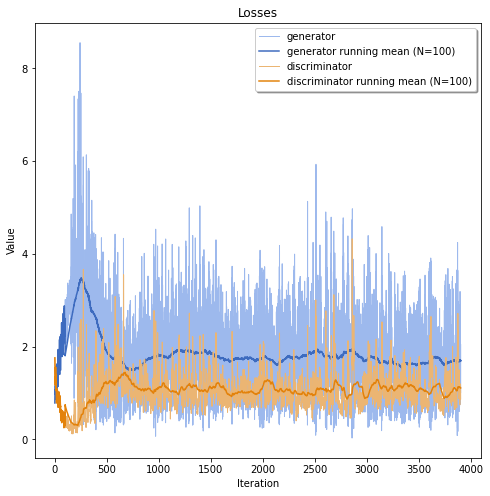

In [18]:
visualize_loss(losses)

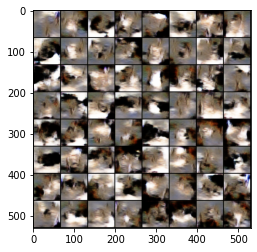

In [19]:
G.eval()
sample = get_sample_image(G)
plt.imshow(sample)

## Save trained models

In [20]:
torch.save(D.state_dict(), f"DCGan-{D.__class__.__name__}-{image_size}-num_epochs={num_epochs}.pt")
torch.save(G.state_dict(), f"DCGan-{G.__class__.__name__}-{image_size}-num_epochs={num_epochs}.pt")

In [21]:
G_state_dict = torch.load("DCGan-Generator-64-num_epochs=5.pt")
D_state_dict = torch.load("DCGan-Discriminator-64-num_epochs=5.pt")

## Load models

In [22]:
generator = Generator()
generator.load_state_dict(G_state_dict)

<All keys matched successfully>

In [23]:
discriminator = Discriminator()
discriminator.load_state_dict(D_state_dict)

<All keys matched successfully>

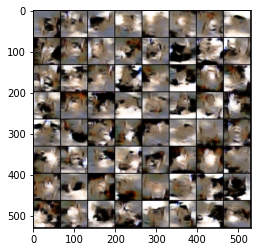

In [24]:
generator.to(device)
generator.eval()
sample = get_sample_image(generator)
plt.imshow(sample)

## Train a few epochs

In [25]:
# Train mode
generator.train()
discriminator.train()

# Train
losses2, images_list2 = train(
    generator=G,
    discriminator=D,
    optims=optims,
    dataloader=dataloader,
    criterion=criterion,
    device=device,
    n_noise=n_noise,
    image_size=image_size,
    num_classes=num_classes,
    epochs=num_epochs,
    discriminator_steps=discriminator_steps,
    batch_size=batch_size
)

# Save
total_epochs = num_epochs + 5
torch.save(D.state_dict(), f"DCGan-{D.__class__.__name__}-{image_size}-num_epochs={total_epochs}.pt")
torch.save(G.state_dict(), f"DCGan-{G.__class__.__name__}-{image_size}-num_epochs={total_epochs}.pt")

Start training...
Batch size: 32
Epoch 0 | Training step: 0
Discriminator Loss: 1.547204852104187
Generator Loss: 1.119344711303711
Epoch 0 | Training step: 500
Discriminator Loss: 0.7902579307556152
Generator Loss: 1.0745776891708374
Epoch time: 114.62935161590576
Epoch 1 | Training step: 1000
Discriminator Loss: 1.4184973239898682
Generator Loss: 0.5127783417701721
Epoch 1 | Training step: 1500
Discriminator Loss: 1.2610529661178589
Generator Loss: 0.9857630133628845
Epoch time: 115.5152952671051
Epoch 2 | Training step: 2000
Discriminator Loss: 3.024552583694458
Generator Loss: 4.4334797859191895
Epoch time: 116.38966226577759
Epoch 3 | Training step: 2500
Discriminator Loss: 1.18495512008667
Generator Loss: 0.8232779502868652
Epoch 3 | Training step: 3000
Discriminator Loss: 1.4472956657409668
Generator Loss: 1.6478843688964844
Epoch time: 117.14724445343018
Epoch 4 | Training step: 3500
Discriminator Loss: 1.140718698501587
Generator Loss: 0.7203840613365173
Epoch 4 | Training ste

In [28]:
%%capture
anim = animate_image_list(images_list+images_list2)

In [29]:
HTML(anim)